#Task 1: Data Preprocessing and Word Embeddings


In [ ]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/IMDB Dataset.csv")

100%|██████████| 25.7M/25.7M [00:00<00:00, 36.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [ ]:
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

def preprocess_text_spacy(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

N = 2500

processed_data = []
for text in tqdm(df.review[:N]):
  processed_data.append(preprocess_text_spacy(text.lower()))

Y = []
for label in tqdm(df.sentiment[:N]):
  Y.append(1 if label == 'positive' else 0)
print('preprocess done')

100%|██████████| 2500/2500 [00:00<00:00, 1137654.33it/s]

preprocess done


In [ ]:
from gensim.models import Word2Vec

cbow_model = Word2Vec(sentences=processed_data, vector_size=100, window=5, min_count=5, sg=0)

skipgram_model = Word2Vec(sentences=processed_data, vector_size=100, window=5, min_count=5, sg=1)

cbow_model.save("cbow_model.model")
skipgram_model.save("skipgram_model.model")

In [ ]:
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
from gensim.models import FastText

fasttext_model = FastText(sentences=processed_data, vector_size=100, window=5, min_count=5)

fasttext_model.save("fasttext_model.model")

In [ ]:
def cosine_similarity(model, word1, word2):
    return model.wv.similarity(word1, word2)

print("CBOW:", cosine_similarity(cbow_model, "movie", "story"))
print("Skip-gram:", cosine_similarity(skipgram_model, "movie", "story"))
print("GloVe:", glove_model.similarity("movie", "story"))
print("FastText:", cosine_similarity(fasttext_model, "movie", "story"))

CBOW: 0.86962485
Skip-gram: 0.57794625
GloVe: 0.7063392
FastText: 0.95958763


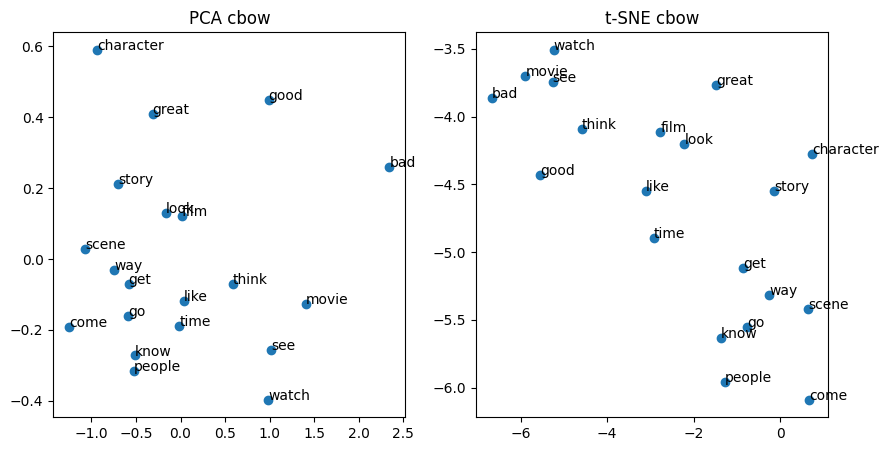

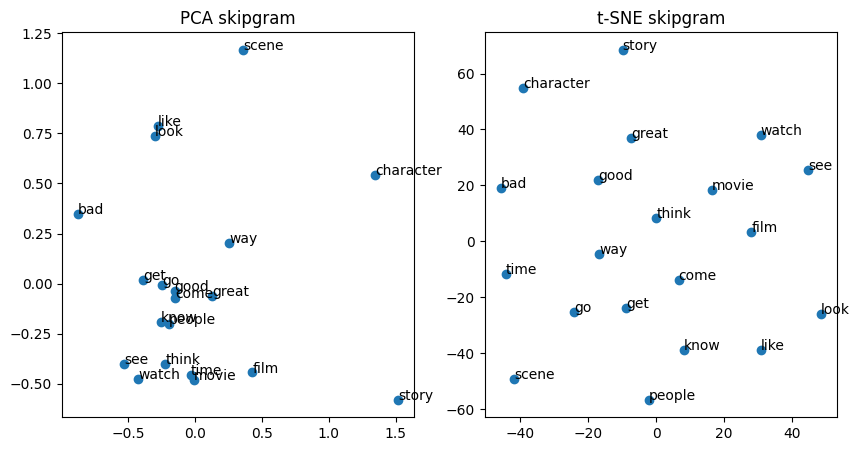

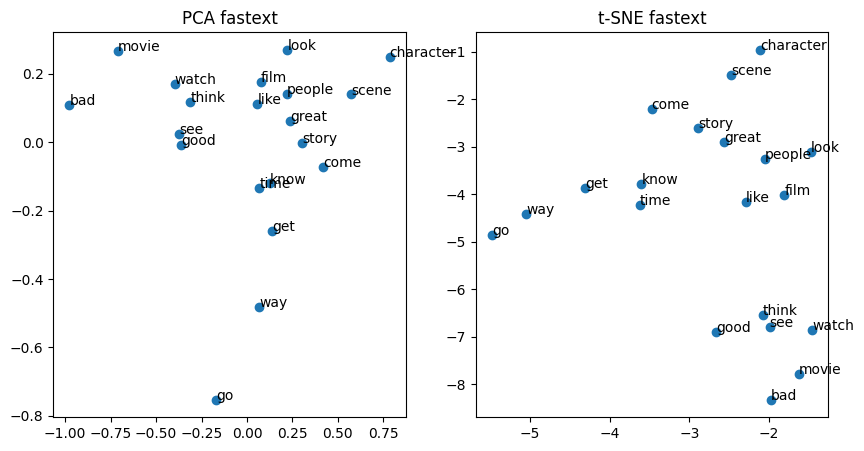

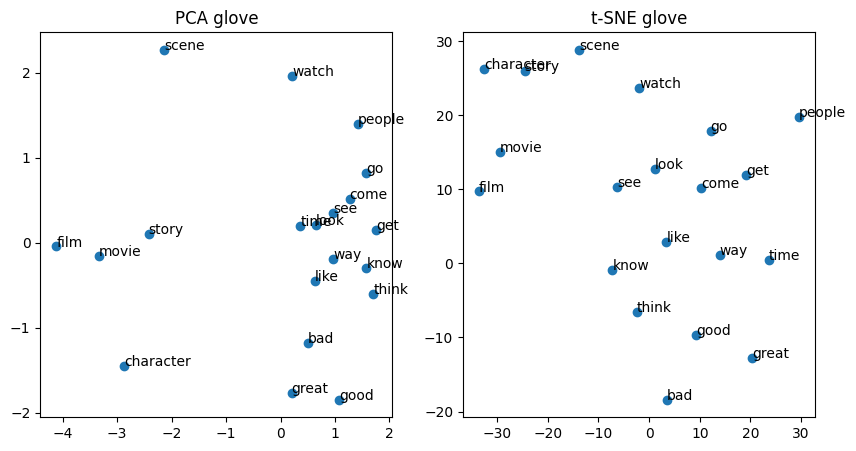

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings(model, words, model_name):
    if model_name == 'glove':
        vectors = np.array([model[word] for word in words])
    else:
        vectors = np.array([model.wv[word] for word in words])

    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    tsne = TSNE(n_components=2, perplexity=10)
    tsne_vectors = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title(f"PCA {model_name}")

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))
    plt.title(f"t-SNE {model_name}")

    plt.show()

top_words = list(cbow_model.wv.index_to_key[:20])

plot_embeddings(cbow_model, top_words, 'cbow')
plot_embeddings(skipgram_model, top_words, 'skipgram')
plot_embeddings(fasttext_model, top_words, 'fastext')
plot_embeddings(glove_model, top_words, 'glove')

#Task 2: Building Recurrent Neural Networks for Sentiment Analysis

In [1]:
len = __builtins__.len
lengths = [len(sub_arr) for sub_arr in processed_data]

counter = 0
for leng in lengths:
  if leng >= 40:
    counter += 1

max_length = max(lengths)
min_length = min(lengths)

print(f"Max length: {max_length}")
print(f"Min length: {min_length}")
print(f"Number of reviews with length >= 40: {counter}")

NameError: name 'processed_data' is not defined

In [ ]:
dl_dataset = []

for review in processed_data:
  if len(review) < 567:
    review.extend([''] * (567 - len(review)))
  else:
    review = review[:567]
  dl_dataset.append(review)

2500


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

vocab_size = 10000
max_length = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training Data Shape: (25000, 200)
Testing Data Shape: (25000, 200)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    SimpleRNN(128, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10


Exception ignored in: <function _xla_gc_callback at 0x7c08c2791620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


391/391 ━━━━━━━━━━━━━━━━━━━━ 75s 33ms/step - accuracy: 0.5011 - loss: 0.7019 - precision: 0.5029 - val_accuracy: 0.5000 - val_loss: 0.7016 - val_precision: 1.0000
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.5075 - loss: 0.6949 - precision: 0.5047 - val_accuracy: 0.4998 - val_loss: 0.6931 - val_precision: 0.4996
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5059 - loss: 0.6939 - precision: 0.5041 - val_accuracy: 0.5000 - val_loss: 0.7030 - val_precision: 0.6667
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5385 - loss: 0.6876 - precision: 0.5388 - val_accuracy: 0.5048 - val_loss: 0.6953 - val_precision: 0.5222
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5537 - loss: 0.6768 - precision: 0.5580 - val_accuracy: 0.5104 - val_loss: 0.7066 - val_precision: 0.5065
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5551 - loss: 0.6564 - precision: 0.5558 - val_accuracy: 0.5100 - val_loss: 

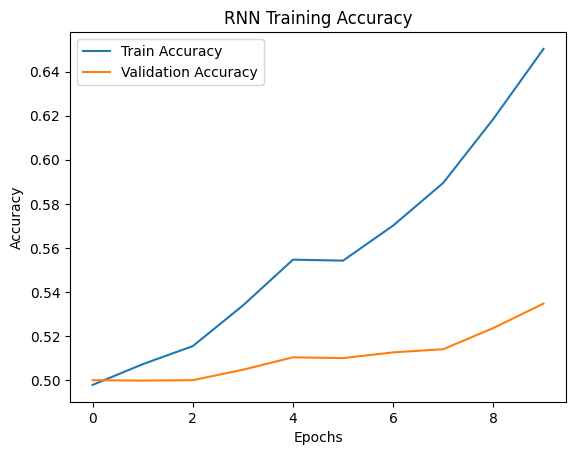

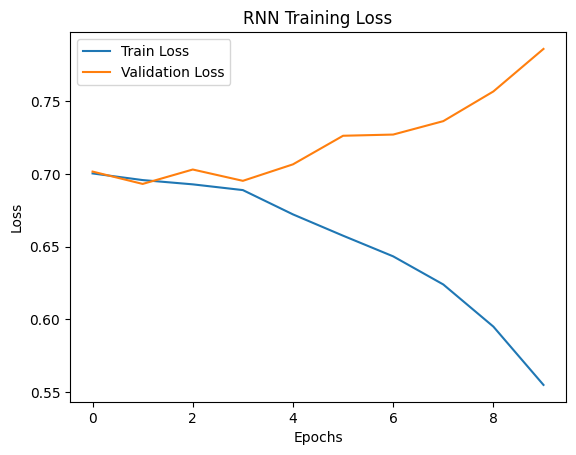

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('RNN Training Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Training Loss')
plt.show()

In [12]:
import tensorflow.keras.backend as K

class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.gradients = []

    def on_batch_end(self, batch, logs=None):

        batch_size = 64
        batch_input = x_train[batch * batch_size : (batch + 1) * batch_size]
        batch_target = y_train[batch * batch_size : (batch + 1) * batch_size]

        with tf.GradientTape() as tape:
            y_pred = self.model(batch_input, training=True)
            y_pred = tf.squeeze(y_pred, axis=-1)
            loss_fn = tf.keras.losses.get(self.model.loss)
            loss = loss_fn(batch_target, y_pred)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        gradient_norms = [tf.norm(g).numpy() if isinstance(g, tf.IndexedSlices) else np.linalg.norm(g.numpy()) for g in gradients if g is not None]
        self.gradients.append(np.mean(gradient_norms))

grad_logger = GradientLogger()
model.fit(x_train, y_train, epochs=3, batch_size=64, callbacks=[grad_logger])

plt.plot(grad_logger.gradients)
plt.xlabel('Batches')
plt.ylabel('Gradient Norm')
plt.title('Vanishing Gradient Effect')
plt.show()

Epoch 1/3


KeyboardInterrupt: 

#Task 3: Implementing LSTM and GRU for Text Classification

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.15VZ3D_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.15VZ3D_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.15VZ3D_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.5021 - loss: 0.6936 - val_accuracy: 0.5015 - val_loss: 0.6933
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5092 - loss: 0.6924 - val_accuracy: 0.5101 - val_loss: 0.6912
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.5250 - loss: 0.6768 - val_accuracy: 0.5159 - val_loss: 0.6897
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.5390 - loss: 0.6548 - val_accuracy: 0.5126 - val_loss: 0.6989
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.5544 - loss: 0.6388 - val_accuracy: 0.6734 - val_loss: 0.6322
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.6655 - loss: 0.5930 - val_accuracy: 0.5115 - val_loss: 0.6979
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.5448 - loss: 0.6407 - val_accuracy: 0.5178 - val_loss: 0.7067
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.5484 - loss: 0.6376 - val_accurac

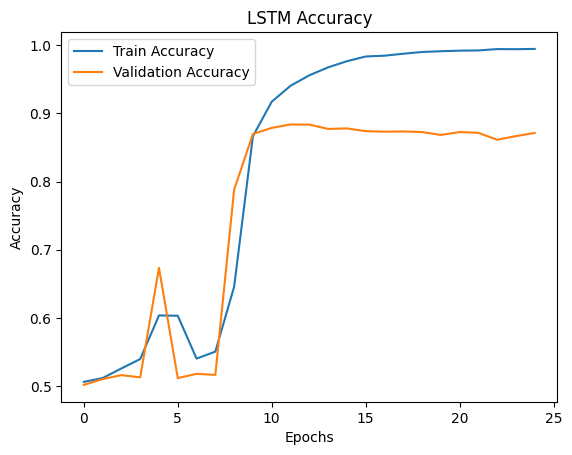

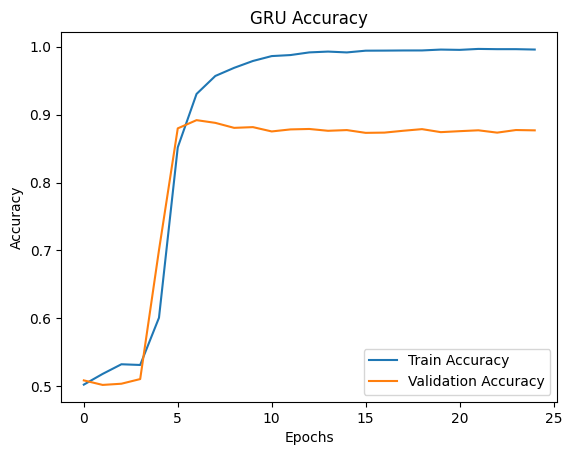

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

dataset, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_data, test_data = dataset["train"], dataset["test"]

def preprocess_data(data, tokenizer, max_length=500):
    sequences, labels = [], []
    for text, label in data:
        tokenized_text = tokenizer.texts_to_sequences([text.numpy().decode('utf-8')])[0]
        sequences.append(tokenized_text)
        labels.append(label.numpy())

    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post')
    return np.array(sequences), np.array(labels)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts([text.numpy().decode('utf-8') for text, _ in train_data])

X_train, y_train = preprocess_data(train_data, tokenizer)
X_test, y_test = preprocess_data(test_data, tokenizer)

def create_model(model_type="LSTM"):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 128, input_length=500),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(128) if model_type == "LSTM" else tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = create_model("LSTM")
lstm_history = lstm_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

gru_model = create_model("GRU")
gru_history = gru_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(lstm_history, "LSTM")
plot_history(gru_history, "GRU")

#Task 4: Text Generation with LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
import random

with open('shake.txt', "r", encoding="utf-8") as f:
    text = f.read().lower()

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

input_sequences = []
words = text.split()
for i in range(1, len(words)):
    n_gram_sequence = words[:i+1]
    encoded = tokenizer.texts_to_sequences([n_gram_sequence])[0]
    input_sequences.append(encoded)

max_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

model = Sequential([
    Embedding(total_words, 128, input_length=max_length-1),
    LSTM(150, return_sequences=True),
    LSTM(100),
    Dense(100, activation='relu'),
    Dense(total_words, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=50, verbose=1)

def generate_text(seed_text, next_words=50):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

print(generate_text("to be or not to be", next_words=50))


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.0304 - loss: 6.6705
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.0342 - loss: 5.9339
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.0329 - loss: 5.8553
Epoch 4/50
 43/119 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.0395 - loss: 5.7786

KeyboardInterrupt: 

#Task 5: Improving Performance with Bidirectional LSTM

In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

vocabular = 12000
maxlen = 250

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabular)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [15]:
model_bilstm = Sequential([
    Embedding(vocabular, 128, input_length=maxlen),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_bilstm = model_bilstm.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 1.0000 - loss: 4.5478e-05 - val_accuracy: 0.8576 - val_loss: 1.1566
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 1.0000 - loss: 3.0679e-05 - val_accuracy: 0.8580 - val_loss: 1.1992
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 1.0000 - loss: 2.4481e-05 - val_accuracy: 0.8586 - val_loss: 1.2373
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 1.0000 - loss: 1.7012e-05 - val_accuracy: 0.8583 - val_loss: 1.2656
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 1.0000 - loss: 1.2109e-05 - val_accuracy: 0.8580 - val_loss: 1.2969
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 1.0000 - loss: 9.3761e-06 - val_accuracy: 0.8584 - val_loss: 1.3272
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 1.0000 - loss: 7.5255e-06 - val_accuracy: 0.8582 - val_loss: 1.3577
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accura

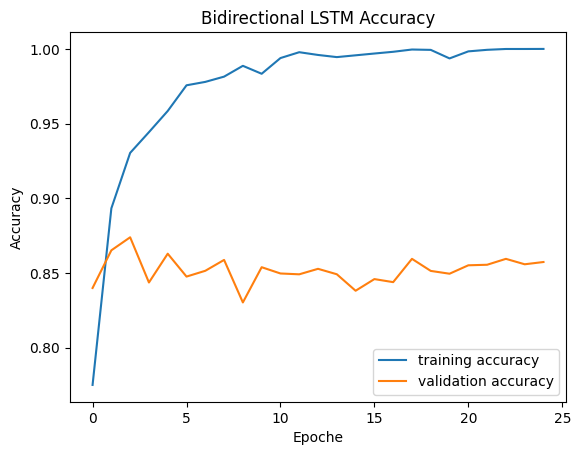

In [17]:
import matplotlib.pyplot as plt

def plot_training_diagram(history, title):
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title(title)
    plt.xlabel('Epoche')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_diagram(history_bilstm, 'Bidirectional LSTM Accuracy')